The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Interconnect's services
Interconnect mainly provides two types of services:

Landline communication. The telephone can be connected to several lines simultaneously.
Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
Some other services the company provides include:

Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
A dedicated technical support line (TechSupport)
Cloud file storage and data backup (OnlineBackup)
TV streaming (StreamingTV) and a movie directory (StreamingMovies)
The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

Data Description
The data consists of files obtained from different sources:

contract.csv — contract information
personal.csv — the client's personal data
internet.csv — information about Internet services
phone.csv — information about telephone services
In each file, the column customerID contains a unique code assigned to each client.

In [1]:
import pandas as pd
import numpy as np
import os, sys
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator, DayLocator, HourLocator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('MAX_ROWS', None)
pd.set_option('MAX_COLUMNS', None)

In [2]:
path = r'/datasets/final_provider/'

In [3]:
contract = pd.read_csv(os.path.join(path, 'contract.csv'))
personal = pd.read_csv(os.path.join(path, 'personal.csv'))
internet = pd.read_csv(os.path.join(path, 'internet.csv'))
phone = pd.read_csv(os.path.join(path, 'phone.csv'))

In [4]:
# shapes
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f'Shape of {file} is {df.shape}')

Shape of contract is (7043, 8)
Shape of personal is (7043, 5)
Shape of internet is (5517, 8)
Shape of phone is (6361, 2)


In [5]:
# top 5
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
# top 5
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
# top 5
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
# top 5
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [9]:
# missing values
contract.isnull().mean()

customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

In [10]:
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [11]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [12]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [13]:
# duplicates?
contract.duplicated().sum()

0

In [14]:
personal.duplicated().sum()

0

In [15]:
phone.duplicated().sum()

0

In [16]:
internet.duplicated().sum()

0

In [17]:
# dtypes
contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [18]:
personal.dtypes

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

In [19]:
phone.dtypes

customerID       object
MultipleLines    object
dtype: object

In [20]:
internet.dtypes

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

In [21]:
# 5 point summary
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [22]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Conclusion

The data is broken into 4 tables: a) Contract - this table describes the payment plan the customer is on, the charges, and if the contract is active or not. b) Personal - this table captures the demographic information about the customer. c) Phone - captures information on whether the customer multiple connections or not. d) Internet - describes the type of internet connection.There are 7043 customers in this dataset. However, when the phone and internet datasets are joined to the contract
datasets there will be missing data in the phone and internet datasets respectively.
There are no missing values, and no duplicate records. The BeginDate and EndDate and TotalCharges need a change of data type; they are stored as objects. The mean monthly charges is 64 dollars and the other plans vary in range.
It appears that there are several boolean features in these data.The target feature - churn, will need to be created using BeginDate and EndDate.

Client Outflow Research
While a model for predicting the churn of clientele is in the process of being created, Interconnect's marketing department has started figuring out different ways of retaining clients. You'll need to collect the necessary information to assist them.

Compare the monthly payment distribution (MonthlyCharges) of all active clients with the clients who have left. Calculate the following statistics for each group: the average, minimum and maximum values, the median, and the values of the 25% and 75% percentiles. Build distribution histograms based on your findings.

Compare the behavior of the clients from the two groups below. For each group, build any two graphs which display:

EDA

Join the 4 dataframes

In [23]:
all_df = personal.merge(contract, left_on=['customerID'], right_on=['customerID'], how='left')
all_df = all_df.merge(phone, left_on=['customerID'], right_on=['customerID'], how='left')
all_df = all_df.merge(internet, left_on=['customerID'], right_on=['customerID'], how='left')

In [24]:
all_df.shape

(7043, 20)

In [25]:
all_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No


Change the datatypes BeginDate, EndDate, and TotalCharges

In [26]:
all_df['BeginDate'] = pd.to_datetime(all_df['BeginDate'], format='%Y-%m-%d')

In [27]:
all_df['EndDate'] = pd.to_datetime(all_df['EndDate'], format='%Y-%m-%d', errors='coerce')

In [28]:
all_df['TotalCharges'] = all_df['TotalCharges'].replace(" ", np.nan).astype(np.float32)

In [29]:
# missing values
all_df['TotalCharges'].isnull().sum()

11

In [30]:
# earliest beingdate
all_df['BeginDate'].min(), all_df['BeginDate'].max()

(Timestamp('2013-10-01 00:00:00'), Timestamp('2020-02-01 00:00:00'))

In [31]:
# earliest enddate
all_df['EndDate'] .min(), all_df['EndDate'].max()


(Timestamp('2019-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

Percent churned

In [32]:
100 * all_df[all_df['EndDate'].notnull()].shape[0] / all_df.shape[0]

26.536987079369588

Create target feature

In [33]:
all_df['is_churned'] = all_df['EndDate'].apply(lambda x: 0 if pd.isna(x) else 1)

In [34]:
all_df['is_churned'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: is_churned, dtype: float64

In [35]:
# mean monthly charges  by is_churned
all_df.groupby('is_churned')['MonthlyCharges'].mean()

is_churned
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64

Compare monthly charges between the churned and active customers

In [36]:
def remove_outliers(df, field):
    """
    Calculate and remove outliers
    for a given Series
    """
    Q1 = df[field].sum(axis=1).quantile(0.25)
    Q3 = df[field].sum(axis=1).quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    # print(df[(df[field].sum(axis=1) > lb) &  (df[field].sum(axis=1) < ub)][field].head())
    return df[(df[field].sum(axis=1) > lb) &  (df[field].sum(axis=1) < ub)][field]

In [37]:
def plot_hist(df, var, bins=30, 
                              title=None, xlabel=None, 
                              legends={},
                              r=1, c=1,
                              by=None,
                              remove_outlier = False,
                              is_facet=False,
                              col=None,
                              row=None,
                              figsize=(9, 7)):
    """
    Plot Histograms of numeric features
    """
    if by:
        axes = df[var].hist(by=df[by], figsize=figsize)
        if is_numeric_dtype(df[by]):
            for ax in axes:
                ax.set_title(legends[int(ax.get_title())])
    if is_facet:
        g = sns.FacetGrid(df, col=col, row=row)
        g.map(plt.hist, var)
        #g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 


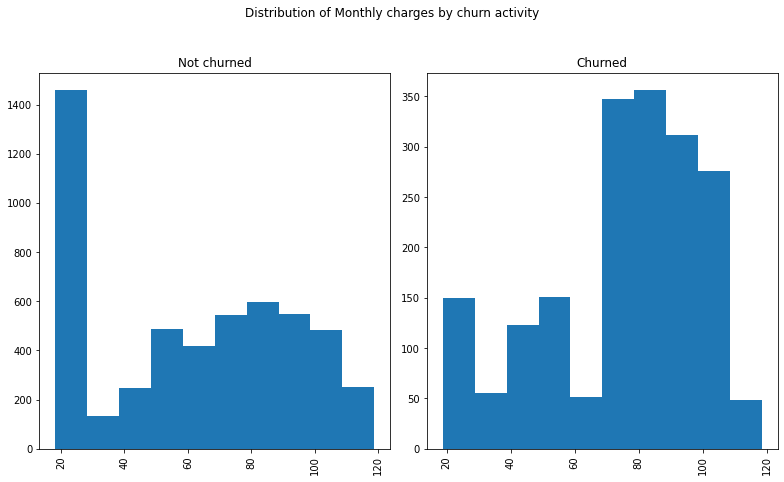

In [38]:
var = 'MonthlyCharges'
plot_hist(all_df, var, bins=30, 
                              title='Distribution of Monthly charges by churn activity', xlabel=None, 
                              legends={0: 'Not churned', 1: 'Churned'},
                              r=1, c=1,
                              by='is_churned',
                              figsize=(11, 7))

In [39]:
# proportion of high spending churned customers
all_df[(all_df['is_churned'] == 1) &
      (all_df['MonthlyCharges'] >= 70)].shape[0] /all_df[(all_df['is_churned'] == 1)].shape[0] 

0.6816479400749064

68% of churned customers are in the high spending category - >= $70, which is not good Most of the customers in the "Not churned" category appear to be low spenders.

In [40]:
# gender count
all_df['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

In [41]:
# mean monthly charges by gender
all_df.groupby('gender')['MonthlyCharges'].mean()

gender
Female    65.204243
Male      64.327482
Name: MonthlyCharges, dtype: float64

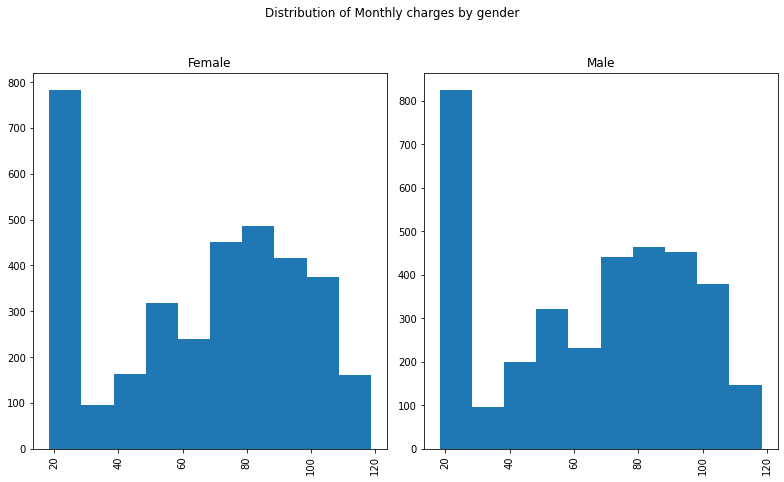

In [42]:
plot_hist(all_df, var, bins=30, 
                              title='Distribution of Monthly charges by gender', xlabel=None, 
                              legends={0: 'Not churned', 1: 'Churned'},
                              r=1, c=1,
                              by='gender',
                              figsize=(11, 7))

The distibution of MonthlyCharges by gender look similar, albeit women are relatively higher spenders in the high-spending
category.

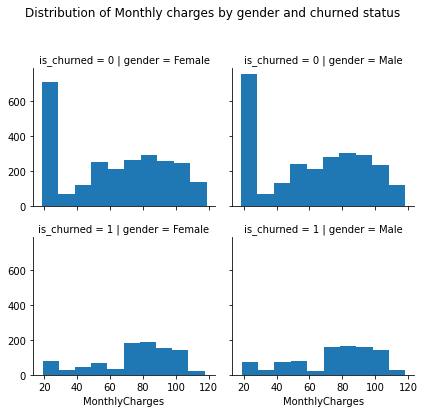

In [43]:
plot_hist(all_df, var, bins=30, 
                              title='Distribution of Monthly charges by gender and churned status', xlabel=None, 
                              r=1, c=1,
                              is_facet=True,
                              col='gender',
                              row='is_churned',
                              figsize=(11, 7))


In [44]:
# proportion of high spending churned customers
all_df[(all_df['is_churned'] == 1) &
      (all_df['MonthlyCharges'] >= 70) &
      (all_df['gender'] == 'Female')].shape[0] /all_df[(all_df['is_churned'] == 1) &
                                                      (all_df['gender'] == 'Female')].shape[0] 

0.6964856230031949

In [45]:
# proportion of senior citizen
all_df['SeniorCitizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

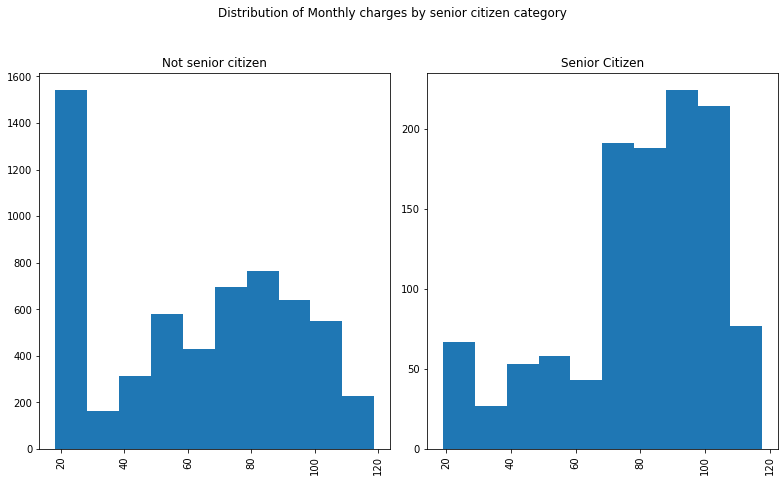

In [46]:
plot_hist(all_df, var, bins=30, 
                              title='Distribution of Monthly charges by senior citizen category', xlabel=None, 
                              legends={0: 'Not senior citizen', 1: 'Senior Citizen'},
                              r=1, c=1,
                              by='SeniorCitizen',
                              figsize=(11, 7))

In [47]:
# number of senior citizens
all_df[(all_df['SeniorCitizen'] == 1)].shape[0] 

1142

In [48]:
# proportion of senior citizens who spend $70 or more
all_df[(all_df['SeniorCitizen'] == 1) &
(all_df['MonthlyCharges'] >= 70)].shape[0] / all_df[(all_df['SeniorCitizen'] == 1)].shape[0] 

0.7556917688266199

While the number of SeniorCitizen is a small group 1142 in all, the distribution of MonthlyCharges by SeniorCitizen category shows that in the senior citizens category most of them around 75 percent are higher spenders.

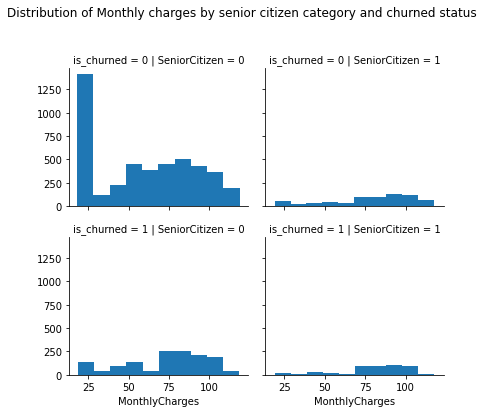

In [49]:
plot_hist(all_df, var, bins=30, 
                              title='Distribution of Monthly charges by senior citizen category and churned status', xlabel=None, 
                              legends={0: 'Not senior citizen', 1: 'Senior Citizen'},
                              r=1, c=1,
                              is_facet=True,
                              col='SeniorCitizen',
                              row='is_churned',
                              figsize=(11, 7))

The facet plot confirms that among SeniorCitizens who've churned, there is a higher percentage of them
who are high spenders.

In [50]:
def bar_plot(df, field, stack, ax=None, aggfunc='size', title=None, axes=None):
    """
    Plot stacked bar plot showing the influence of the 
    target variable on the independent variable
    """
    df.pivot_table(index=field, columns=stack, aggfunc=aggfunc).plot(kind='bar',
                                                                    stacked=False,
                                                                    title=title, 
                                                                    ax=ax,
#                                                                    fontsize=20,
                                                                    figsize=(15, 15),
                                                                    )
    axes.flat[-1].set_visible(False) 
    plt.tight_layout()

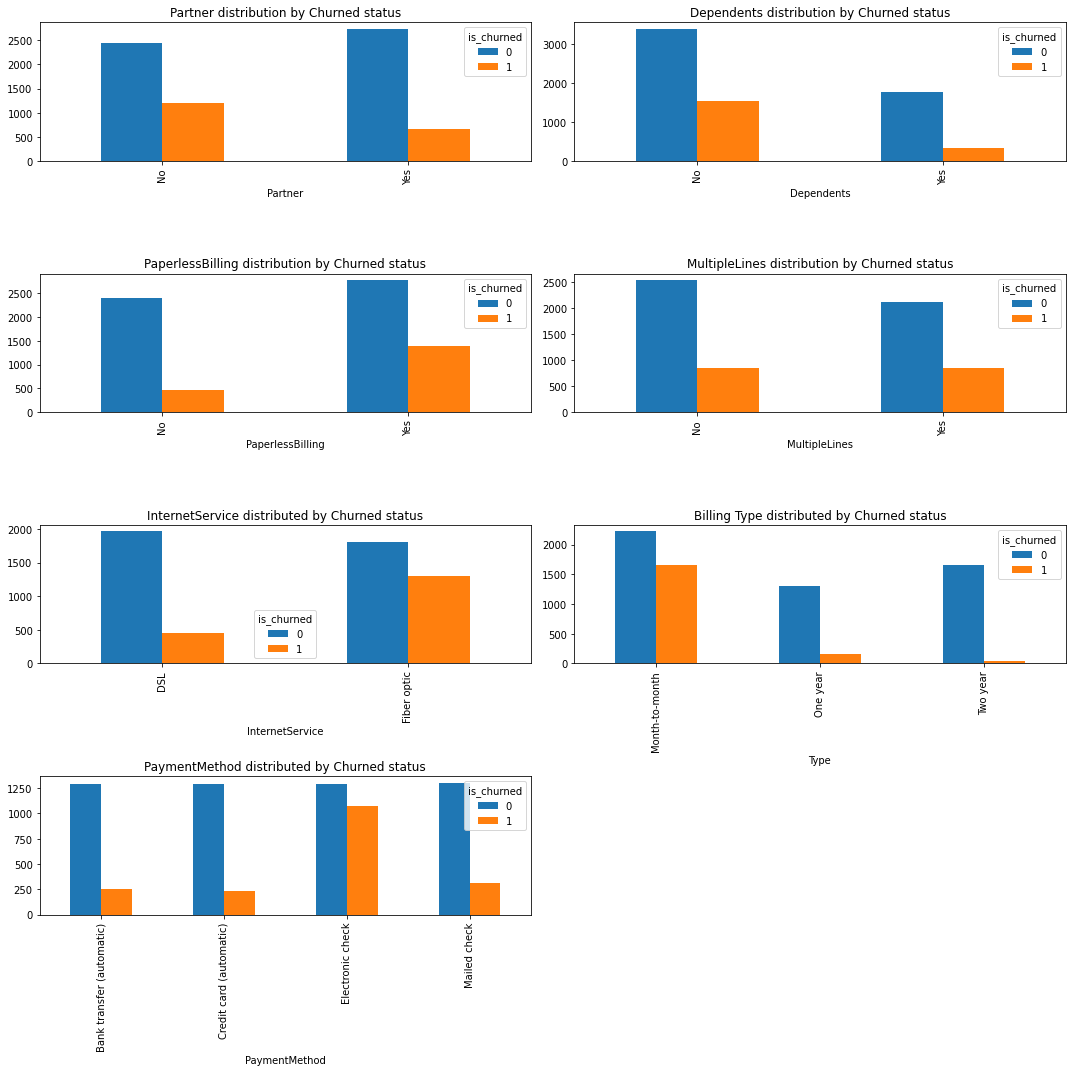

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(15, 7))
cols = {
        'Partner': 'Partner distribution by Churned status',
        'Dependents': 'Dependents distribution by Churned status',
        'PaperlessBilling': 'PaperlessBilling distribution by Churned status',
        'MultipleLines': 'MultipleLines distribution by Churned status', 
        'InternetService': 'InternetService distributed by Churned status',
        'Type': 'Billing Type distributed by Churned status',
        'PaymentMethod': 'PaymentMethod distributed by Churned status'
}
for i, (field, title) in enumerate(cols.items()):
    bar_plot(all_df, field, 'is_churned', aggfunc='size', ax=axes.flatten()[i], title=title, axes=axes)

The height of the churned bar for customers without partners is relatively higher than the height of the churned
bar for customers with partners. A similar pattern is noted for customers without dependents.
Churning is relatively higher for people who have opted for Paperless billing. Customers with month-to-month billing
plan have noticed a relatively higher number of churns. There appears to be no difference in height of the churn bar for customers with/without multiple telephone lines. Fiber optic is not popular among the churned customers.

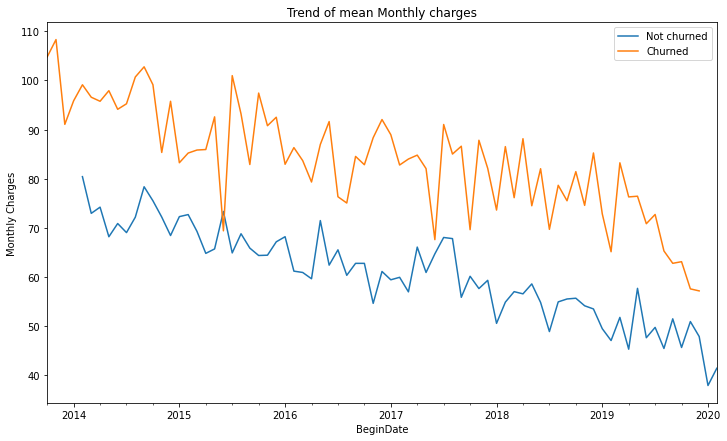

In [52]:
fig, ax = plt.subplots()
for target in [0, 1]:
    all_df[all_df['is_churned'] == target].groupby('BeginDate')['MonthlyCharges'].mean().plot(label=target, 
                                                                                             figsize=(12, 7),
                                                                                             )
plt.legend(labels=['Not churned', 'Churned'])
plt.xlabel('BeginDate')
plt.ylabel('Monthly Charges')
#ax.xaxis.set_major_locator(YearLocator())
#ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.title('Trend of mean Monthly charges')
plt.show()

The mean MonthlyCharges trend shows a decline in revenue. Interestingly, the churners have a relatively higher mean
spend compared with the Non-churners.

In [53]:
all_df['is_churned'].value_counts()

0    5174
1    1869
Name: is_churned, dtype: int64

In [54]:
all_df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Conclusion

1869(27%) of the customers have churned during the period from 2013-10-01 to 2020-02-01.
68 percent of the churned customers have spent $70 or more per month.
There is an almost equal number of male and female customers. However, female customers, on average, spend slightly
more on their Monthly bills than do male customers. Among the churned customers, 69 percent of female customers spend around 69 dollars compared to men which is 67 dollars. There are also 1142 customers that are seniorcitizens and 76 percent of them spend over 70 dollars on there monthly bills.
Other behaviour I noted among the churned customers are customers with no dependents or partners tend to easily churn. Monthly billing gives them an easy exit option. As well as Paperless billing and Fiber optic internet plan have been a thorn in retaining such customers.
The MonthlyCharges trend in the last 7 years has exprienced a decline in revenue, with churned customers generating
an average of 74 dollars which is relative to the non churned customers who have spent 61 dollars.

Carifying questions
Do we have data on which cities the telco's customers are from?

Do we have any information on tickets? The Marketing team can identify pain points not resolved by the customer
support, and how long it took to resolve them?

Do we have the ages of the customers or age range? This information will help the marketing team bucket the
groups appropriately.

Do we know why there are missing values for TotalCharges, including internet and phone data? These customers
have paid for their usage.

Any information on the charges for the various services offered? This will help us infer the missing values better
for TotalCharges.

Do we split the data into 3 parts? On which dataset are we testing the model's AUC-ROC?

Work plan
We will Explore the data to understand which segment of the customers have churned. This will include the exploratory analysis around gender, senior citizen and characteristics of the customers have revealed some useful insights into this question.
We will join all the datasets using the CustomerId by making a left join with personal data. This is required for modeling.
There are a couple of ways to fill missing values for TotalCharges, try to infer the missing values using MonthlyCharges and
BeginDate. For the phone and internet data, we should try using mode to fill the value. Then building a Logistic Regression model to populate the missing values one by one to avoid any bias.
for feature engineering which creates new features. Which are the number of days between EndDate and BeginDate and thats for active customers use 2020-02-01 as the end date. We will then Calculate the number of payments made using MonthlyCharges and TotalCharges. Thats how we can create date features from BeginDate such as year, month, day and dayofweek.

For modeling:
Convert all the boolean features using One hot encoding. For Type and PaymentMethods use Ordinal encoding. Change the data types after conversion to reduce the data size. Lets drop redundant features such as CustomerId, BeginDate and EndDate.
We will then stratify and split the datasets into train, valid and test. Use the test set only once with each model. We also are going to take into acount the imbalance and use the class_weights argument available in the respective models that will be used. Or do you think maybe upsampling the under represented class? I am pretty sure if we use 5-fold cross validation with gridsearch to find good hyperparameters. That can create a solid base model. But additionally createing 3 models like LogisticRegression, RandomForestClassifier and CatBoostClassifier will be perfect to pick the best performing model.
If you have any other suggestions please let me know!

Add features
num_days = EndDate - BeginDate

num_payments = TotalCharges - 'MonthlyCharges`

year = year(BeginDate)

month = month(BeginDate)

day of week = dayofweek(BeginDate)

In [55]:
all_df['num_days'] = (
    all_df[['EndDate', 
            'BeginDate']]
            .apply(lambda x: datetime.datetime.strptime('2020-02-01', '%Y-%m-%d') - x[1] 
                   if pd.isna(x[0]) 
                   else x[0] - x[1], axis=1
                  )
).dt.days

In [56]:
all_df['year'] = all_df['BeginDate'].dt.year
all_df['month'] = all_df['BeginDate'].dt.month
# all_df['day'] = all_df['BeginDate'].dt.day
all_df['dayofweek'] = all_df['BeginDate'].dt.dayofweek

Split the data

In [57]:
num_col_to_impute = ['TotalCharges']
cat_col_to_impute = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies']
col_to_drop = ['BeginDate', 'EndDate', 'customerID']
col_to_drop2 = ['BeginDate', 'EndDate', 'customerID', 'num_days',]

In [58]:
# dataset with num_days
train_X, test_X = train_test_split(all_df.drop(col_to_drop, axis=1), 
                                                    stratify=all_df['is_churned'], 
                random_state=42, test_size=0.2)

In [59]:
train_X.shape, test_X.shape

((5634, 22), (1409, 22))

In [60]:
# dataset with num_days
train_X2, test_X2, train_y2, test_y2 = train_test_split(all_df.drop(col_to_drop2, axis=1), all_df['is_churned'], 
                                                    stratify=all_df['is_churned'], 
                random_state=42, test_size=0.2)

In [61]:
train_X2.shape, test_X2.shape, train_y2.shape, test_y2.shape

((5634, 21), (1409, 21), (5634,), (1409,))

Impute the missing categorical and numerical features

In [62]:
# before impute mean and median for TotalCharges
train_X['TotalCharges'].mean(), train_X['TotalCharges'].median()

(2302.6042, 1398.125)

In [63]:
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
num_imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')

In [64]:
train_X[num_col_to_impute] = num_imputer.fit_transform(train_X[num_col_to_impute])
train_X2[num_col_to_impute] = num_imputer2.fit_transform(train_X2[num_col_to_impute])

In [65]:
test_X[num_col_to_impute] = num_imputer.transform(test_X[num_col_to_impute])
test_X2[num_col_to_impute] = num_imputer2.transform(test_X2[num_col_to_impute])

In [66]:
# mean after imputing Total Charges
train_X['TotalCharges'].mean(), train_X['TotalCharges'].median()

(2301.3199505648545, 1398.125)

In [67]:
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_imputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [68]:
train_X[cat_col_to_impute] = cat_imputer.fit_transform(train_X[cat_col_to_impute])
train_X2[cat_col_to_impute] = cat_imputer2.fit_transform(train_X2[cat_col_to_impute])

In [69]:
test_X[cat_col_to_impute] = cat_imputer.transform(test_X[cat_col_to_impute])
test_X2[cat_col_to_impute] = cat_imputer2.transform(test_X2[cat_col_to_impute])

In [70]:
# check missing
train_X.isnull().mean()

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
is_churned          0.0
num_days            0.0
year                0.0
month               0.0
dayofweek           0.0
dtype: float64

In [71]:
test_X.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
is_churned          0
num_days            0
year                0
month               0
dayofweek           0
dtype: int64

In [72]:
# create a new feature number of payments post imputation
train_X['num_pmt'] = train_X['TotalCharges'] / train_X['MonthlyCharges']
test_X['num_pmt'] = test_X['TotalCharges'] / test_X['MonthlyCharges']

train_X2['num_pmt'] = train_X2['TotalCharges'] / train_X2['MonthlyCharges']
test_X2['num_pmt'] = test_X2['TotalCharges'] / test_X2['MonthlyCharges']

Standard scaler

In [73]:
std = StandardScaler()
std2 = StandardScaler()

In [74]:
train_X[['MonthlyCharges', 
         'TotalCharges', 
         'num_days',
        'num_pmt',
        'year',
        'month',
        'dayofweek']] = std.fit_transform(train_X[['MonthlyCharges', 
                                                   'TotalCharges', 
                                                   'num_days', 
                                                   'num_pmt',
                                                  'year',
                                                  'month',
                                                 'dayofweek']])

train_X2[['MonthlyCharges', 
         'TotalCharges', 
        'num_pmt',
        'year',
        'month',
        'dayofweek']] = std2.fit_transform(train_X2[['MonthlyCharges', 
                                                   'TotalCharges', 
                                                   'num_pmt',
                                                  'year',
                                                  'month',
                                                 'dayofweek']])

In [75]:
test_X[['MonthlyCharges', 
        'TotalCharges',
       'num_days',
       'num_pmt',
        'year',
        'month',
        'dayofweek']] = std.transform(test_X[['MonthlyCharges', 
                                              'TotalCharges', 
                                              'num_days', 
                                              'num_pmt',
                                              'year',
                                              'month',
                                              'dayofweek']])

test_X2[['MonthlyCharges', 
        'TotalCharges',
       'num_pmt',
        'year',
        'month',
        'dayofweek']] = std2.transform(test_X2[['MonthlyCharges', 
                                              'TotalCharges', 
                                              'num_pmt',
                                              'year',
                                              'month',
                                              'dayofweek']])

Ordinal Encoding

In [76]:
oe = OrdinalEncoder()
oe2 = OrdinalEncoder()

In [77]:
train_X[['Type', 'PaymentMethod']] = oe.fit_transform(train_X[['Type', 'PaymentMethod']])
train_X2[['Type', 'PaymentMethod']] = oe2.fit_transform(train_X2[['Type', 'PaymentMethod']])

In [78]:
test_X[['Type', 'PaymentMethod']] = oe.transform(test_X[['Type', 'PaymentMethod']])
test_X2[['Type', 'PaymentMethod']] = oe2.transform(test_X2[['Type', 'PaymentMethod']])

In [79]:
train_X['SeniorCitizen'] = train_X['SeniorCitizen'].astype(str)
test_X['SeniorCitizen'] = test_X['SeniorCitizen'].astype(str)

train_X2['SeniorCitizen'] = train_X2['SeniorCitizen'].astype(str)
test_X2['SeniorCitizen'] = test_X2['SeniorCitizen'].astype(str)

In [80]:
cols_to_dummify = train_X.select_dtypes(include=['object']).columns.tolist()
train_X = pd.concat([train_X, pd.get_dummies(train_X[cols_to_dummify], drop_first=True)], axis=1)
test_X = pd.concat([test_X, pd.get_dummies(test_X[cols_to_dummify], drop_first=True)], axis=1)

train_X2 = pd.concat([train_X2, pd.get_dummies(train_X2[cols_to_dummify], drop_first=True)], axis=1)
test_X2 = pd.concat([test_X2, pd.get_dummies(test_X2[cols_to_dummify], drop_first=True)], axis=1)

In [81]:
# drop the columns that are dummified
train_X = train_X.drop(cols_to_dummify, axis=1)
test_X = test_X.drop(cols_to_dummify, axis=1)

train_X2 = train_X2.drop(cols_to_dummify, axis=1)
test_X2 = test_X2.drop(cols_to_dummify, axis=1)

In [82]:
train_X.shape, test_X.shape

((5634, 23), (1409, 23))

In [83]:
train_X.head()

,Type,PaymentMethod,MonthlyCharges,TotalCharges,is_churned,num_days,year,month,dayofweek,num_pmt,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
3738,0.0,2.0,-0.521976,-0.263290,0,0.103688,0.065426,-0.949793,-0.606922,0.082725,1,0,0,0,0,0,0,0,0,1,0,1,1
3151,0.0,3.0,0.337478,-0.504815,0,-0.712030,0.572459,1.285434,-0.105323,-0.700269,1,0,1,1,0,0,1,1,0,0,0,0,0
4860,2.0,3.0,-0.809013,-0.751214,0,-0.793602,1.079491,-1.508600,-1.108520,-0.731787,1,0,1,1,0,0,0,1,1,0,1,0,0
3867,2.0,1.0,0.284384,-0.173700,0,-0.264054,0.065426,1.564838,0.396275,-0.269408,0,0,1,0,1,0,0,0,1,1,0,1,1
3810,0.0,2.0,-0.676279,-0.990851,0,-1.281696,1.586524,-1.508600,-0.606922,-1.283201,1,0,1,1,0,0,0,0,0,0,0,0,0


In [84]:
train_X2.shape, test_X2.shape

((5634, 22), (1409, 22))

Change the dtype for the integers

In [85]:
train_X.dtypes

Type                           float64
PaymentMethod                  float64
MonthlyCharges                 float64
TotalCharges                   float64
is_churned                       int64
num_days                       float64
year                           float64
month                          float64
dayofweek                      float64
num_pmt                        float64
gender_Male                      uint8
SeniorCitizen_1                  uint8
Partner_Yes                      uint8
Dependents_Yes                   uint8
PaperlessBilling_Yes             uint8
MultipleLines_Yes                uint8
InternetService_Fiber optic      uint8
OnlineSecurity_Yes               uint8
OnlineBackup_Yes                 uint8
DeviceProtection_Yes             uint8
TechSupport_Yes                  uint8
StreamingTV_Yes                  uint8
StreamingMovies_Yes              uint8
dtype: object

In [86]:
def change_dtypes(df, field, dtype='np.int16'):
    """
    Change or lower the dtype for an existing
    field
    """
    try:
        df[field] = df[field].astype(dtype=dtype)
    except:
        print(f'Dtype conversion failed for {field}')

In [87]:
cols = {
        'Type': np.uint8, 
        'PaymentMethod': np.uint8,
}
for field, dtype in cols.items():
    change_dtypes(train_X, field, dtype)
    change_dtypes(test_X, field, dtype)
    change_dtypes(train_X2, field, dtype)
    change_dtypes(test_X2, field, dtype)

In [88]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 3738 to 5639
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         5634 non-null   uint8  
 1   PaymentMethod                5634 non-null   uint8  
 2   MonthlyCharges               5634 non-null   float64
 3   TotalCharges                 5634 non-null   float64
 4   is_churned                   5634 non-null   int64  
 5   num_days                     5634 non-null   float64
 6   year                         5634 non-null   float64
 7   month                        5634 non-null   float64
 8   dayofweek                    5634 non-null   float64
 9   num_pmt                      5634 non-null   float64
 10  gender_Male                  5634 non-null   uint8  
 11  SeniorCitizen_1              5634 non-null   uint8  
 12  Partner_Yes                  5634 non-null   uint8  
 13  Dependents_Yes 

Modeling

In [89]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 
        
         # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)

In [90]:
def roc_auc_scorer(y_true, y_pred):
    """
    Use the customer scorer for roc_auc_score
    inside GridSearch
    """
    return roc_auc_score(y_true, y_pred)

In [91]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict_proba(train_X)[:, 1]
        best_score = roc_auc_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'cat':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict_proba(test_X)[:, 1]
    best_score = roc_auc_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

In [92]:
target = 'is_churned'
features_train, target_train = train_X.drop([target], axis=1), train_X[target]
features_test, target_test = test_X.drop([target], axis=1), test_X[target]

features_train2, target_train2 = train_X2.drop([target], axis=1), train_X2[target]
features_test2, target_test2 = test_X2.drop([target], axis=1), test_X2[target]

In [93]:
features_train.head()

,Type,PaymentMethod,MonthlyCharges,TotalCharges,num_days,year,month,dayofweek,num_pmt,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PaperlessBilling_Yes,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
3738,0,2,-0.521976,-0.263290,0.103688,0.065426,-0.949793,-0.606922,0.082725,1,0,0,0,0,0,0,0,0,1,0,1,1
3151,0,3,0.337478,-0.504815,-0.712030,0.572459,1.285434,-0.105323,-0.700269,1,0,1,1,0,0,1,1,0,0,0,0,0
4860,2,3,-0.809013,-0.751214,-0.793602,1.079491,-1.508600,-1.108520,-0.731787,1,0,1,1,0,0,0,1,1,0,1,0,0
3867,2,1,0.284384,-0.173700,-0.264054,0.065426,1.564838,0.396275,-0.269408,0,0,1,0,1,0,0,0,1,1,0,1,1
3810,0,2,-0.676279,-0.990851,-1.281696,1.586524,-1.508600,-0.606922,-1.283201,1,0,1,1,0,0,0,0,0,0,0,0,0


In [94]:
dc = DummyClassifier()
best_dc_model, best_dc_auc, best_dc_time = build_model(dc, features_train, target_train, 
                                                        features_test, target_test,
                                                        hyperparameters={}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=2, model_str='dummy')

          train  test
Accuracy   0.73  0.73
F1         0.00  0.00
APS        0.27  0.27
ROC AUC    0.50  0.50


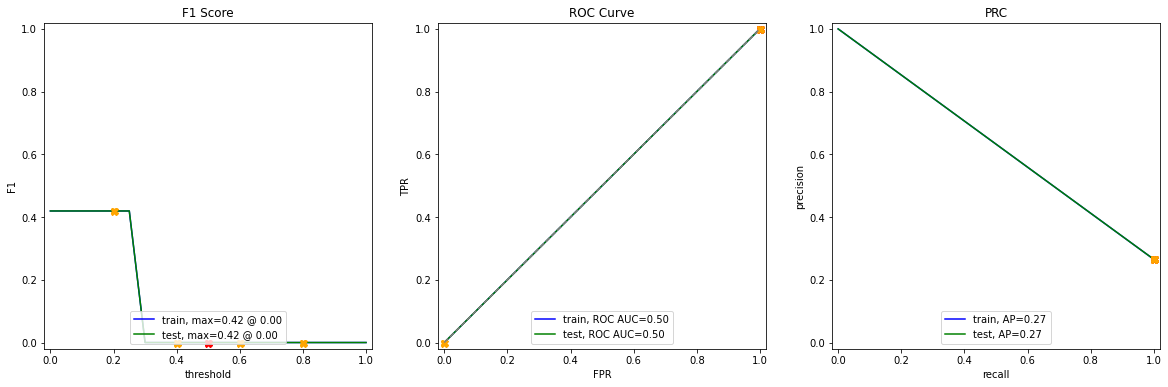

In [95]:
evaluate_model(best_dc_model, features_train, target_train, 
                                    features_test, target_test)

Logistic Regression with Target Leakage

In [96]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
best_lr_model, best_lr_auc, best_lr_time = build_model(lr, features_train, target_train, 
                                                        features_test, target_test,
                                                        hyperparameters={'C' : [.001, .01, .1, 1, 10]}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5)

          train  test
Accuracy   0.99  0.99
F1         0.98  0.98
APS        1.00  1.00
ROC AUC    1.00  1.00


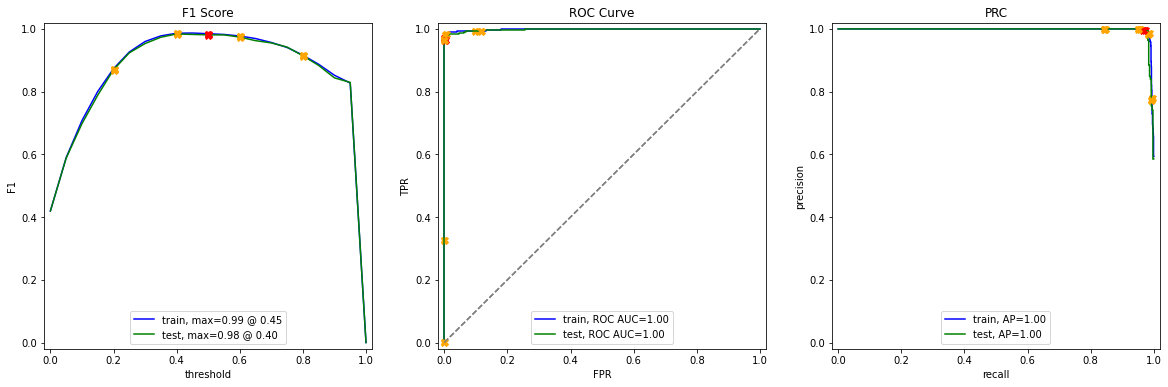

In [97]:
evaluate_model(best_lr_model, features_train, target_train, 
                            features_test, target_test)

Logistic Regression without Target Leakage

In [98]:
lr2 = LogisticRegression(class_weight='balanced', random_state=42)
best_lr2_model, best_lr2_auc, best_lr2_time = build_model(lr2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'C' : [.001, .01, .1, 1, 10]}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5)

          train  test
Accuracy   0.92  0.91
F1         0.86  0.85
APS        0.94  0.94
ROC AUC    0.97  0.97


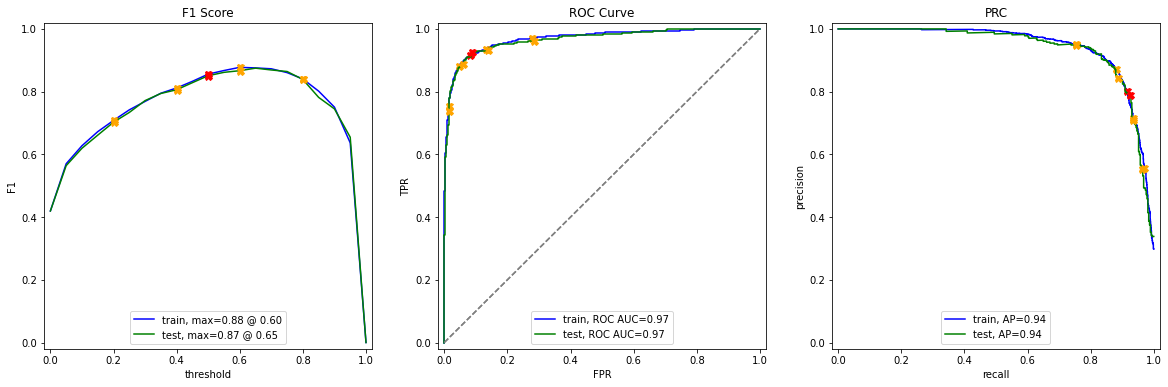

In [99]:
evaluate_model(best_lr2_model, features_train2, target_train2, 
                            features_test2, target_test2)

Random Forest with Target Leakage

In [100]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
best_rf_model, best_rf_auc, best_rf_time = build_model(rf, features_train, target_train, 
                                                        features_test, target_test,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(roc_auc_scorer, 
                                   needs_threshold=True,
                                   ), cv=5)

          train  test
Accuracy   0.89  0.83
F1         0.82  0.71
APS        0.92  0.82
ROC AUC    0.97  0.91


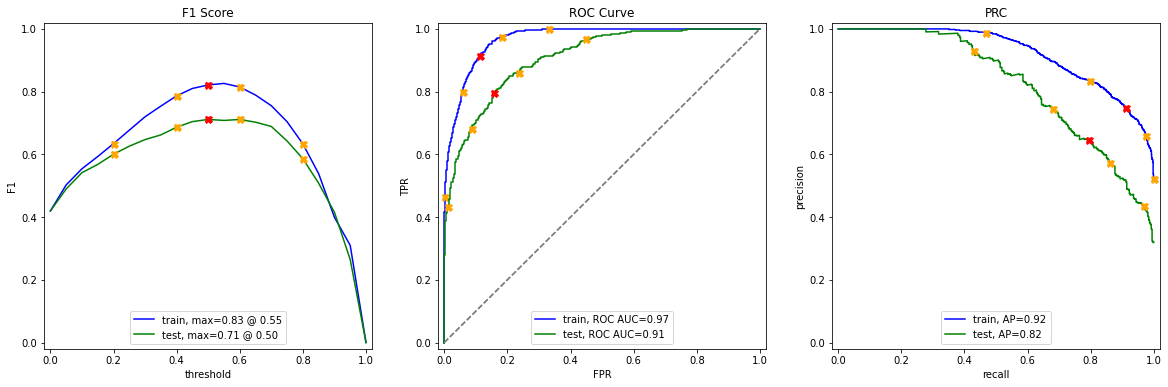

In [101]:
evaluate_model(best_rf_model, features_train, target_train, 
                            features_test, target_test)

Random Forest without Target Leakage

In [102]:
rf2 = RandomForestClassifier(class_weight='balanced', random_state=42)
best_rf2_model, best_rf2_auc, best_rf2_time = build_model(rf2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5)

          train  test
Accuracy   0.88  0.80
F1         0.80  0.67
APS        0.90  0.78
ROC AUC    0.96  0.89


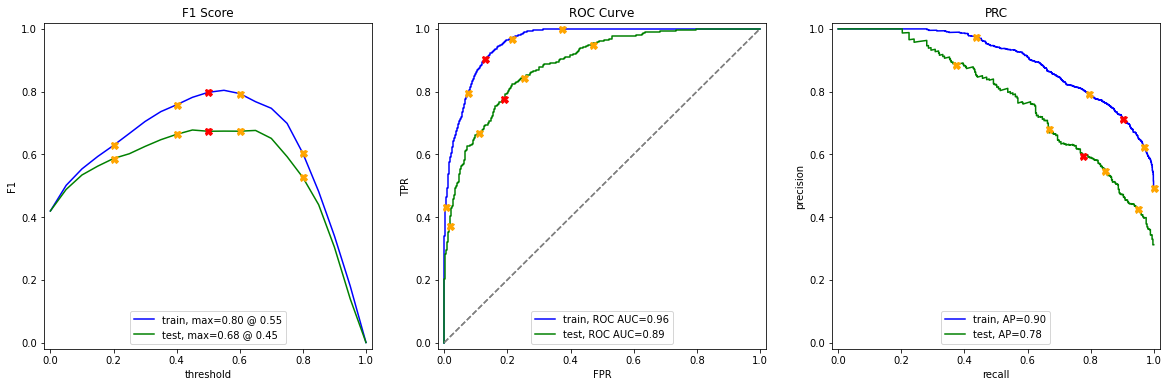

In [103]:
evaluate_model(best_rf2_model, features_train2, target_train2, 
                            features_test2, target_test2)

CatBooster with Target Leakage

In [104]:
cat_features = train_X.select_dtypes(include=[np.uint8]).columns
cat = CatBoostClassifier(learning_rate=0.2, loss_function='Logloss',
                       random_seed=42)
best_cb_model, best_cb_auc, best_cb_time = build_model(cat, features_train, target_train, 
                                                        features_test, target_test,
                                                        hyperparameters={'iterations': range(100, 600, 100)}, 
                scoring=make_scorer(roc_auc_scorer, 
                                    needs_threshold=True,
                                    ), cv=5, model_str='catboost',
           cat_features=cat_features)

0:	learn: 0.5589778	total: 50ms	remaining: 4.95s
1:	learn: 0.4728948	total: 53.7ms	remaining: 2.63s
2:	learn: 0.4170506	total: 57.4ms	remaining: 1.86s
3:	learn: 0.3868008	total: 61.1ms	remaining: 1.47s
4:	learn: 0.3613130	total: 64.4ms	remaining: 1.22s
5:	learn: 0.3424669	total: 67.9ms	remaining: 1.06s
6:	learn: 0.3260831	total: 71.5ms	remaining: 950ms
7:	learn: 0.3198189	total: 75.2ms	remaining: 865ms
8:	learn: 0.3127743	total: 78.6ms	remaining: 795ms
9:	learn: 0.3078677	total: 82.2ms	remaining: 740ms
10:	learn: 0.3051014	total: 85.5ms	remaining: 692ms
11:	learn: 0.2784859	total: 89ms	remaining: 653ms
12:	learn: 0.2715960	total: 92.3ms	remaining: 618ms
13:	learn: 0.2691529	total: 95.8ms	remaining: 589ms
14:	learn: 0.2574417	total: 99.2ms	remaining: 562ms
15:	learn: 0.2451063	total: 103ms	remaining: 539ms
16:	learn: 0.2432017	total: 106ms	remaining: 518ms
17:	learn: 0.2378487	total: 110ms	remaining: 500ms
18:	learn: 0.2310848	total: 114ms	remaining: 485ms
19:	learn: 0.2293439	total: 11

Cat Booster without Target Leakage

In [105]:
cat_features = train_X2.select_dtypes(include=[np.uint8]).columns
cat2 = CatBoostClassifier(learning_rate=0.2, l2_leaf_reg=5, depth=5, loss_function='Logloss',
                        random_seed=42)
best_cb2_model, best_cb2_auc, best_cb2_time = build_model(cat2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                       hyperparameters={'iterations': range(100, 600, 100)
                                                                        }, 
                scoring= roc_auc_scorer, cv=5, model_str='catboost',
           cat_features=cat_features)

0:	learn: 0.5693333	total: 2.72ms	remaining: 270ms
1:	learn: 0.5117549	total: 5.33ms	remaining: 261ms
2:	learn: 0.4622069	total: 7.69ms	remaining: 249ms
3:	learn: 0.4345624	total: 10.2ms	remaining: 244ms
4:	learn: 0.4144066	total: 12.6ms	remaining: 240ms
5:	learn: 0.4030418	total: 15.1ms	remaining: 237ms
6:	learn: 0.3957319	total: 17.5ms	remaining: 233ms
7:	learn: 0.3899484	total: 19.9ms	remaining: 229ms
8:	learn: 0.3706836	total: 22.3ms	remaining: 225ms
9:	learn: 0.3661368	total: 24.7ms	remaining: 223ms
10:	learn: 0.3626532	total: 27ms	remaining: 219ms
11:	learn: 0.3599826	total: 29.3ms	remaining: 215ms
12:	learn: 0.3501880	total: 31.7ms	remaining: 212ms
13:	learn: 0.3476098	total: 34.5ms	remaining: 212ms
14:	learn: 0.3441128	total: 36.9ms	remaining: 209ms
15:	learn: 0.3414770	total: 39.3ms	remaining: 206ms
16:	learn: 0.3405679	total: 41.7ms	remaining: 203ms
17:	learn: 0.3390034	total: 44.1ms	remaining: 201ms
18:	learn: 0.3379385	total: 46.4ms	remaining: 198ms
19:	learn: 0.3342045	tot

          train  test
Accuracy   0.95  0.92
F1         0.89  0.83
APS        0.97  0.93
ROC AUC    0.98  0.96


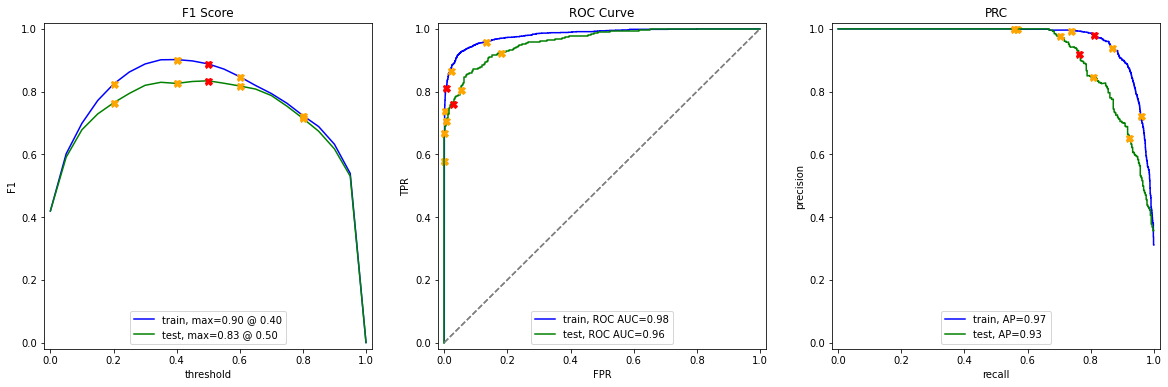

In [106]:
evaluate_model(best_cb2_model, features_train2, target_train2, 
                            features_test2, target_test2)

In [107]:
# best features from cb model
pd.DataFrame(best_cb2_model.feature_importances_, index=features_train2.columns.tolist()).sort_values(0, ascending=False)

,0
num_pmt,35.685506
month,26.746557
year,8.705746
Type,7.214218
TotalCharges,6.606016
MonthlyCharges,6.195070
dayofweek,2.933615
PaymentMethod,1.176041
InternetService_Fiber optic,0.805938
OnlineSecurity_Yes,0.486987


In [108]:
model_results_df = pd.DataFrame({'model': ['LogisticRegression', 
                                           'LogisticRegression2',
                                           'RandomForestClassifier',
                                           'RandomForestClassifier2', 
                                           'CatBoostClassifier',
                                           'CatBoostClassifier2'],
              'best_auc': [best_lr_auc, best_lr2_auc, best_rf_auc, best_rf2_auc, best_cb_auc, best_cb2_auc],
              'train_time': [best_lr_time, best_lr2_time, best_rf_time, best_rf2_time, best_cb_time, best_cb2_time]})

In [109]:
model_results_df

,model,best_auc,train_time
0,LogisticRegression,0.998127,5.91
1,LogisticRegression2,0.966261,4.72
2,RandomForestClassifier,0.908471,194.64
3,RandomForestClassifier2,0.887233,190.84
4,CatBoostClassifier,0.999964,35.25
5,CatBoostClassifier2,0.959185,23.46


Conclusion

The best model is the Logistic Regression2 model. I did 7 models a dummy model, a Logistic Regression (0), Random Forest (2), and catboost(4) were done but had Target Leakage. so I also did them without leakage, and that is Logistic Regression (1), Random Forest(3) and the Catboost (5). of all of these the Logistic Regression2 (1) yielded the best results. at 97 percent for the auc time.